In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from collections import Counter
import datetime
import wordcloud
import json

In [ ]:
from google.colab import files


uploaded = files.upload()


Saving dataset.csv to dataset.csv


In [ ]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/dataset.csv'
df = pd.read_csv(file_path)

In [ ]:
import requests, sys, time, os, argparse

# List of simple to collect features
snippet_features = ["title",
                    "publishedAt",
                    "channelId",
                    "channelTitle",
                    "categoryId"]

# Any characters to exclude, generally these are things that become problematic in CSV files
unsafe_characters = ['\n', '"']

# Used to identify columns, currently hardcoded order
header = ["video_id"] + snippet_features + ["trending_date", "tags", "view_count", "likes", "dislikes",
                                            "comment_count", "thumbnail_link", "comments_disabled",
                                            "ratings_disabled", "description"]


def setup(api_path, code_path):
    with open(api_path, 'r') as file:
        api_key = file.readline()

    with open(code_path) as file:
        country_codes = [x.rstrip() for x in file]

    return api_key, country_codes


def prepare_feature(feature):
    # Removes any character from the unsafe characters list and surrounds the whole item in quotes
    for ch in unsafe_characters:
        feature = str(feature).replace(ch, "")
    return f'"{feature}"'


def api_request(page_token, country_code):
    # Builds the URL and requests the JSON from it
    request_url = f"https://www.googleapis.com/youtube/v3/videos?part=id,statistics,snippet{page_token}chart=mostPopular&regionCode={country_code}&maxResults=50&key={api_key}"
    request = requests.get(request_url)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()
    return request.json()


def get_tags(tags_list):
    # Takes a list of tags, prepares each tag and joins them into a string by the pipe character
    return prepare_feature("|".join(tags_list))


def get_videos(items):
    lines = []
    for video in items:
        comments_disabled = False
        ratings_disabled = False

        # We can assume something is wrong with the video if it has no statistics, often this means it has been deleted
        # so we can just skip it
        if "statistics" not in video:
            continue

        # A full explanation of all of these features can be found on the GitHub page for this project
        video_id = prepare_feature(video['id'])

        # Snippet and statistics are sub-dicts of video, containing the most useful info
        snippet = video['snippet']
        statistics = video['statistics']

        # This list contains all of the features in snippet that are 1 deep and require no special processing
        features = [prepare_feature(snippet.get(feature, "")) for feature in snippet_features]

        # The following are special case features which require unique processing, or are not within the snippet dict
        description = snippet.get("description", "")
        thumbnail_link = snippet.get("thumbnails", dict()).get("default", dict()).get("url", "")
        trending_date = time.strftime("%y.%d.%m")
        tags = get_tags(snippet.get("tags", ["[none]"]))
        view_count = statistics.get("viewCount", 0)

        # This may be unclear, essentially the way the API works is that if a video has comments or ratings disabled
        # then it has no feature for it, thus if they don't exist in the statistics dict we know they are disabled
        if 'likeCount' in statistics and 'dislikeCount' in statistics:
            likes = statistics['likeCount']
            dislikes = statistics['dislikeCount']
        else:
            ratings_disabled = True
            likes = 0
            dislikes = 0

        if 'commentCount' in statistics:
            comment_count = statistics['commentCount']
        else:
            comments_disabled = True
            comment_count = 0

        # Compiles all of the various bits of info into one consistently formatted line
        line = [video_id] + features + [prepare_feature(x) for x in [trending_date, tags, view_count, likes, dislikes,
                                                                       comment_count, thumbnail_link, comments_disabled,
                                                                       ratings_disabled, description]]
        lines.append(",".join(line))
    return lines


def get_pages(country_code, next_page_token="&"):
    country_data = []

    # Because the API uses page tokens (which are literally just the same function of numbers everywhere) it is much
    # more inconvenient to iterate over pages, but that is what is done here.
    while next_page_token is not None:
        # A page of data i.e. a list of videos and all needed data
        video_data_page = api_request(next_page_token, country_code)

        # Get the next page token and build a string which can be injected into the request with it, unless it's None,
        # then let the whole thing be None so that the loop ends after this cycle
        next_page_token = video_data_page.get("nextPageToken", None)
        next_page_token = f"&pageToken={next_page_token}&" if next_page_token is not None else next_page_token

        # Get all of the items as a list and let get_videos return the needed features
        items = video_data_page.get('items', [])
        country_data += get_videos(items)

    return country_data


def write_to_file(country_code, country_data):

    print(f"Writing {country_code} data to file...")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(f"{output_dir}/{time.strftime('%y.%d.%m')}_{country_code}_videos.csv", "w+", encoding='utf-8') as file:
        for row in country_data:
            file.write(f"{row}\n")


def get_data():
    for country_code in country_codes:
        country_data = [",".join(header)] + get_pages(country_code)
        write_to_file(country_code, country_data)


if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--key_path', help='Path to the file containing the api key, by default will use api_key.txt in the same directory', default='api_key.txt')
    parser.add_argument('--country_code_path', help='Path to the file containing the list of country codes to scrape, by default will use country_codes.txt in the same directory', default='country_codes.txt')
    parser.add_argument('--output_dir', help='Path to save the outputted files in', default='output/')

    args = parser.parse_args()

    output_dir = args.output_dir
    api_key, country_codes = setup(args.key_path, args.country_code_path)

    get_data()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset.csv")

In [ ]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"à¤ªà¥€à¤°à¤¿à¤¯à¤¡à¥à¤¸ à¤•à¥‡ à¤¸à¤®à¤¯, à¤ª...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"à¤ªà¥€à¤°à¤¿à¤¯à¤¡à¥à¤¸ à¤•à¥‡ à¤¸à¤®à¤¯|""à¤ª...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"à¤ªà¥€à¤°à¤¿à¤¯à¤¡à¥à¤¸ à¤•à¥‡ à¤¸à¤®à¤¯, à¤ª..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11713 entries, 0 to 11712
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                11713 non-null  object
 1   trending_date           11713 non-null  object
 2   title                   11713 non-null  object
 3   channel_title           11713 non-null  object
 4   category_id             11713 non-null  int64 
 5   publish_time            11713 non-null  object
 6   tags                    11713 non-null  object
 7   views                   11713 non-null  int64 
 8   likes                   11713 non-null  int64 
 9   dislikes                11713 non-null  int64 
 10  comment_count           11713 non-null  int64 
 11  thumbnail_link          11713 non-null  object
 12  comments_disabled       11713 non-null  bool  
 13  ratings_disabled        11713 non-null  bool  
 14  video_error_or_removed  11713 non-null  bool  
 15  de

In [ ]:
df[df["description"].apply(lambda x: pd.isna(x))].head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
24,znOC3IU0dF8,17.14.11,Hero Tarun at #ChaySamWeddingReception | Saman...,News Mantra,24,2017-11-13T06:03:49.000Z,Hero Tarun At Samantha Naga Chaitanya Wedding ...,55178,45,94,15,https://i.ytimg.com/vi/znOC3IU0dF8/default.jpg,False,False,False,NaN
25,z3V9LUA6VQM,17.14.11,à°†à°®à±† à°¬à±à°¯à°¾à°‚à°•à± à°…à°•à±Œà°‚à°...,OmFut,24,2017-11-12T09:45:58.000Z,[none],236710,858,197,66,https://i.ytimg.com/vi/z3V9LUA6VQM/default.jpg,False,False,False,NaN
36,qP67alYxSiU,17.14.11,à°•à±†à°®à±†à°°à°¾à°²à±‹ à°°à°¿à°•à°¾à°°à±à°¡...,HOTNEWS TELUGU,26,2017-11-12T03:53:49.000Z,"Miracles Caught on Camera|""Miracles Caught on ...",128851,0,0,0,https://i.ytimg.com/vi/qP67alYxSiU/default.jpg,True,True,False,NaN


In [ ]:
df["description"] = df["description"].fillna(value="")

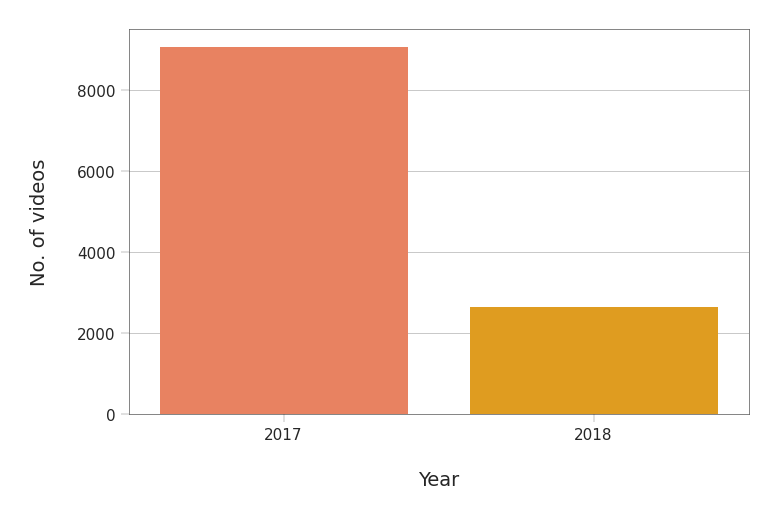

In [ ]:
cdf = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf,
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

ParserError: ignored

NameError: ignored

NameError: ignored

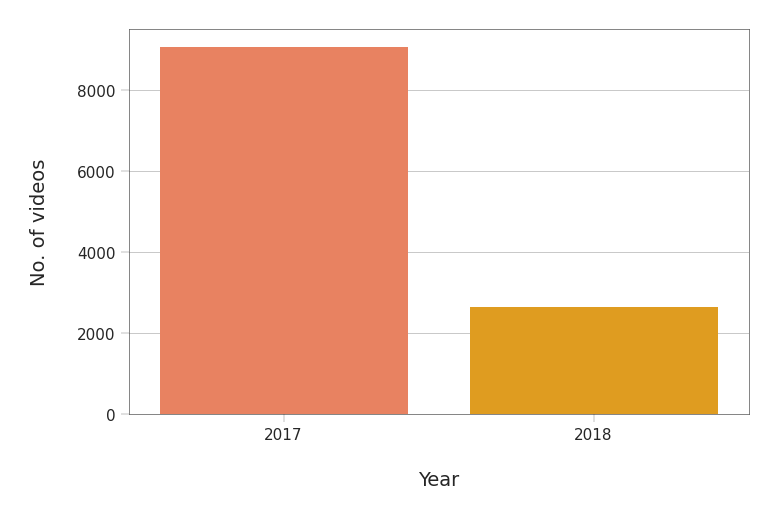

In [ ]:
cdf = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf,
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

In [ ]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,11713.00,11713.00,11713.00,11713.00,11713.00
mean,21.82,846185.77,21496.02,1677.98,2358.35
std,6.52,3605652.55,107205.65,27531.67,19826.05
min,1.00,5098.00,0.00,0.00,0.00
25%,23.00,87008.00,564.00,74.00,49.00
50%,24.00,204104.00,1930.00,217.00,222.00
75%,24.00,551612.00,7802.00,706.00,846.00
max,43.00,125432237.00,2912710.00,1545017.00,827755.00


<ipython-input-42-0b55f1bc9a2d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df["views"], kde=False, color=PLOT_COLORS[4],


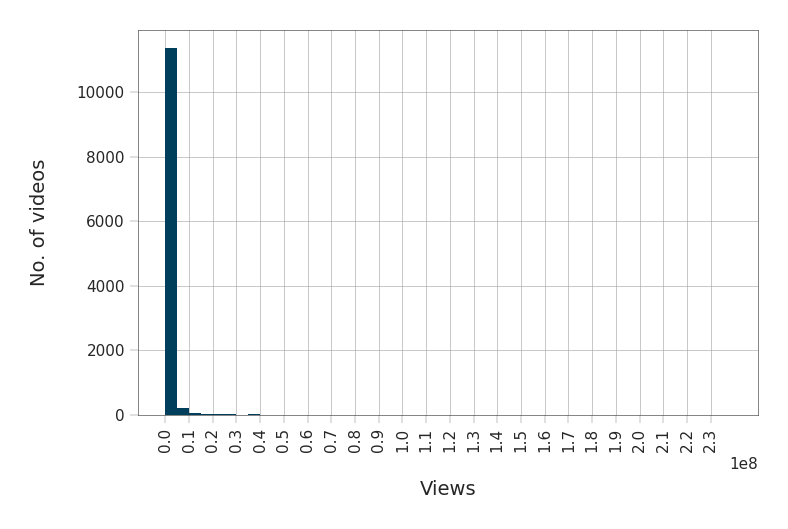

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df["views"], kde=False, color=PLOT_COLORS[4],
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

<ipython-input-43-cc75f20121dc>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False,


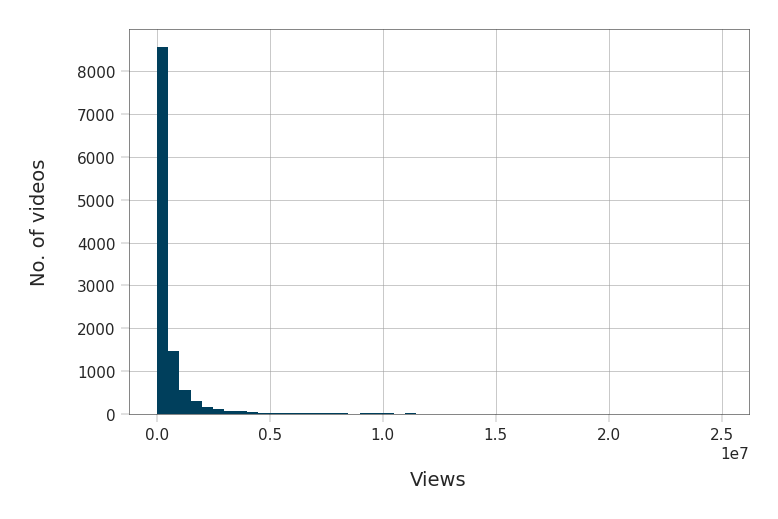

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

In [ ]:
df[df['views'] < 1e6]['views'].count() / df['views'].count() * 100

85.61427473747119

<ipython-input-45-d71743ff234d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df["likes"], kde=False,


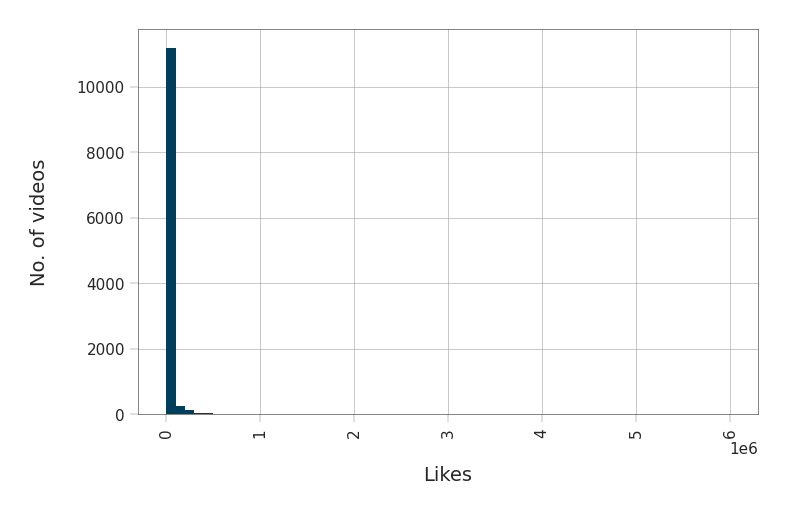

In [ ]:
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = plt.xticks(rotation=90)

<ipython-input-46-a26351ea86e9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df[df["likes"] <= 1e5]["likes"], kde=False,


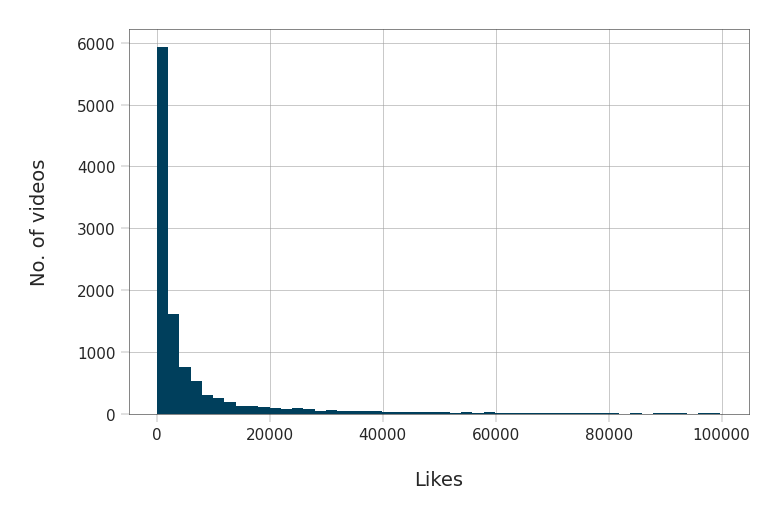

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["likes"] <= 1e5]["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")

In [ ]:
df[df['likes'] < 4e4]['likes'].count() / df['likes'].count() * 100

90.76240075130198

<ipython-input-49-b71715540cb3>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df["comment_count"], kde=False, rug=False,


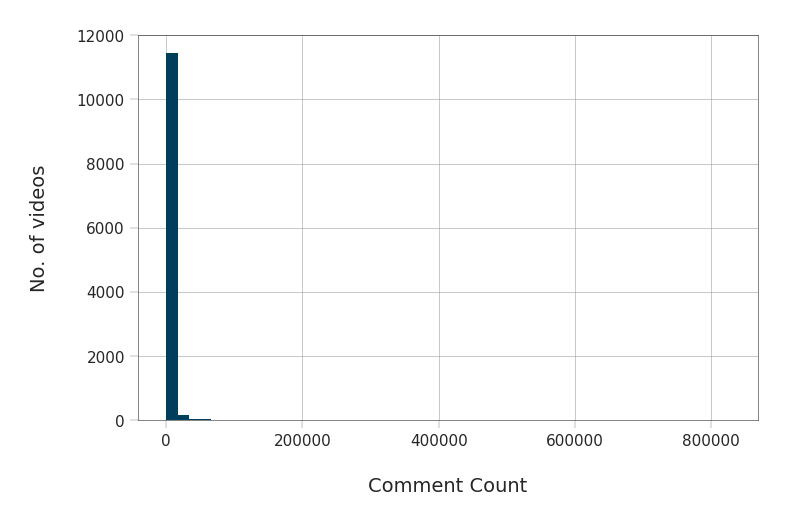

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df["comment_count"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

<ipython-input-50-de96b792ef6f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df[df["comment_count"] < 200000]["comment_count"], kde=False, rug=False,


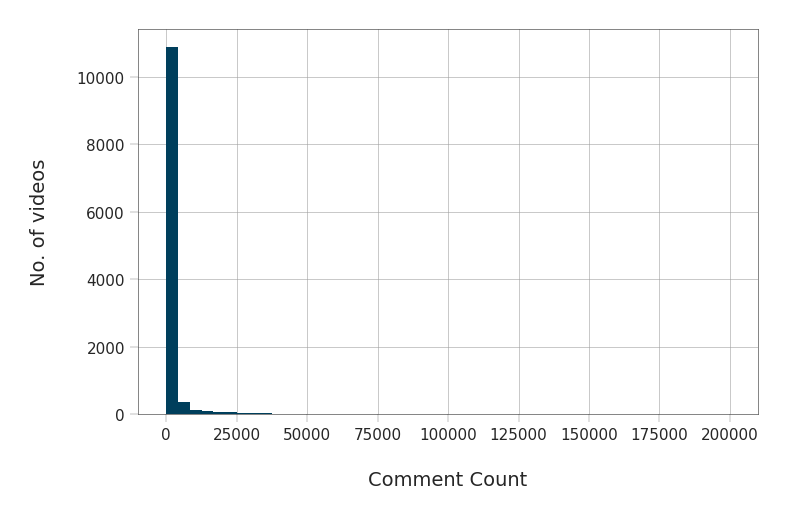

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["comment_count"] < 200000]["comment_count"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 2e5, 49), ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

In [ ]:
df[df['comment_count'] < 4000]['comment_count'].count() / df['comment_count'].count() * 100

92.48698027832323

In [ ]:
df.describe(include = ['O'])

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,11713,11713,11713,11713,11713,11713,11713,11713
unique,5769,63,5919,1003,5783,4709,5840,5095
top,#NAME?,17.14.11,DJ (Duvvada Jagannadham) 2017 New Released Ful...,etvteluguindia,2017-12-08T13:30:00.000Z,[none],https://i.ytimg.com/vi/ZJDMWVZta3M/default.jpg,
freq,143,200,9,64,11,518,9,217


In [ ]:
grouped = df.groupby("video_id")
groups = []
wanted_groups = []
for key, item in grouped:
    groups.append(grouped.get_group(key))

for g in groups:
    if len(g['title'].unique()) != 1:
        wanted_groups.append(g)

wanted_groups[0]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
134,#NAME?,17.14.11,à°¸â€Œà°®à°‚à°¤ à°•à°‚à°Ÿâ€Œà°¤â€Œà°¡à°¿ | Sam...,Friday Poster,24,2017-11-13T08:59:27.000Z,"à°¸â€Œà°®à°‚à°¤ à°•à°‚à°Ÿâ€Œà°¤â€Œà°¡à°¿|""Sama...",31052,36,11,2,https://i.ytimg.com/vi/-b0ww7L2MGU/default.jpg,False,False,False,à°¸â€Œà°®à°‚à°¤ à°•à°‚à°Ÿâ€Œà°¤â€Œà°¡à°¿ | Sam...
173,#NAME?,17.14.11,à¤•à¥à¤‚à¤­ à¤°à¤¾à¤¶à¤¿ à¤µà¤¾à¤²à¥‹à¤‚ à¤•à...,Jansatta,25,2017-11-11T09:09:06.000Z,"à¤•à¥à¤‚à¤­ à¤°à¤¾à¤¶à¤¿|""Astro""|""rashi""|""à¤•...",30659,180,36,3,https://i.ytimg.com/vi/-BcG_jN6DgE/default.jpg,False,False,False,
189,#NAME?,17.14.11,à¤˜à¤° à¤®à¥‡à¤‚ à¤šà¥à¤ªà¤šà¤¾à¤ª à¤¯à¤¹à¤¾à...,Health Tips for You,26,2017-11-08T12:27:17.000Z,"tona totka|""tone""|""laal kitaab""|""lal kitaab""|""...",743321,2570,1154,294,https://i.ytimg.com/vi/-kj6W27Jj-8/default.jpg,False,False,False,à¤˜à¤° à¤®à¥‡à¤‚ à¤šà¥à¤ªà¤šà¤¾à¤ª à¤¯à¤¹à¤¾à...
298,#NAME?,17.15.11,18 à¤¨à¤µà¤®à¥à¤¬à¤° 2017à¤¶à¤¨à¤¿ à¤…à¤®à¤¾à...,AstroMitram,22,2017-11-14T05:41:47.000Z,"Tiger Zinda Hai Trailer|""Tiger Zinda Hai Offic...",28816,376,31,29,https://i.ytimg.com/vi/-X33hZ1oTXI/default.jpg,False,False,False,à¤¶à¤¨à¤¿ à¤…à¤®à¤¾à¤µà¤¸à¥à¤¯à¤¾ 18 à¤¨à¤µà¤...
360,#NAME?,17.15.11,BEST MOM EVER- Things you would love to hear f...,Old Delhi Films,24,2017-11-14T06:52:06.000Z,"Mother|""mom""|""best mom""|""best dad ever""|""best ...",14529,1018,131,83,https://i.ytimg.com/vi/-x9Bp5lFyM0/default.jpg,False,False,False,"Things your MOTHER will never say, still you r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11581,#NAME?,18.16.01,Real Sociedad vs Barcelona 2-4 - All Goals & E...,GOLAZO TV,17,2018-01-14T21:44:55.000Z,"Real Sociedad|""vs""|""Barcelona""|""2-4""|""Goals""|""...",3709068,34607,1462,3412,https://i.ytimg.com/vi/-aFZP64c180/default.jpg,False,False,False,Real Sociedad vs Barcelona 2-4 - All Goals & E...
11643,#NAME?,18.16.01,TVF INMATES | S01E05 | Reaction w/ Chuck & Olena!,jaby koay,24,2018-01-14T11:00:00.000Z,"tvf|""inmates""|""trailer""|""reaction""|""jaby koay""...",66230,1227,55,319,https://i.ytimg.com/vi/-Pp1VZiqOOs/default.jpg,False,False,False,Download the #StardustApp on Apple or Android ...
11681,#NAME?,18.16.01,Venkatesh Scenes | To Be Add in Pawan Kalyan |...,ETV Telangana,25,2018-01-12T12:37:11.000Z,"ETV|""ETVTelugu""|""ETV NewsVideo""|""National News...",217573,1732,148,58,https://i.ytimg.com/vi/-D_b573lrrY/default.jpg,False,False,False,Venkatesh Scenes | To Be Add in Pawan Kalyan |...
11686,#NAME?,18.16.01,Sketch 2-Minute Review | Chiyaan Vikram | Tama...,Fully Filmy,1,2018-01-12T10:15:46.000Z,"Fully Filmy|""Abishek Raja""|""VJ Abishek""|""VJ Ab...",183634,3664,150,209,https://i.ytimg.com/vi/-vmRGTBc7cM/default.jpg,False,False,False,Here is the 2-minute review of the movie Sketc...


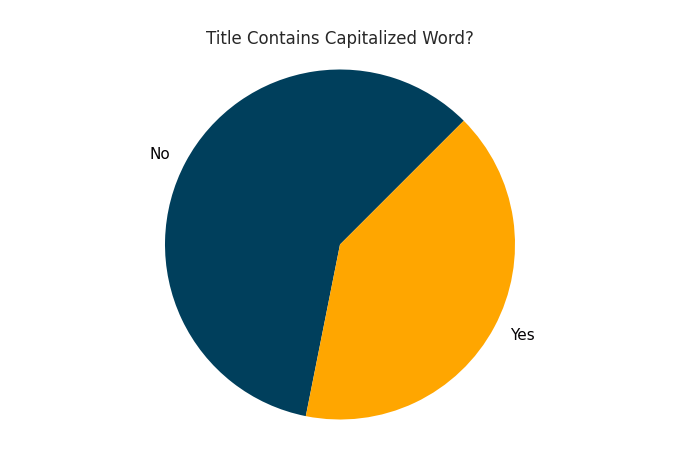

In [ ]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)

value_counts = df["contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'],
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

In [ ]:
df["contains_capitalized"].value_counts(normalize=True)

False   0.59
True    0.41
Name: contains_capitalized, dtype: float64

<ipython-input-57-e6d651d6430c>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(df["title_length"], kde=False, rug=False,


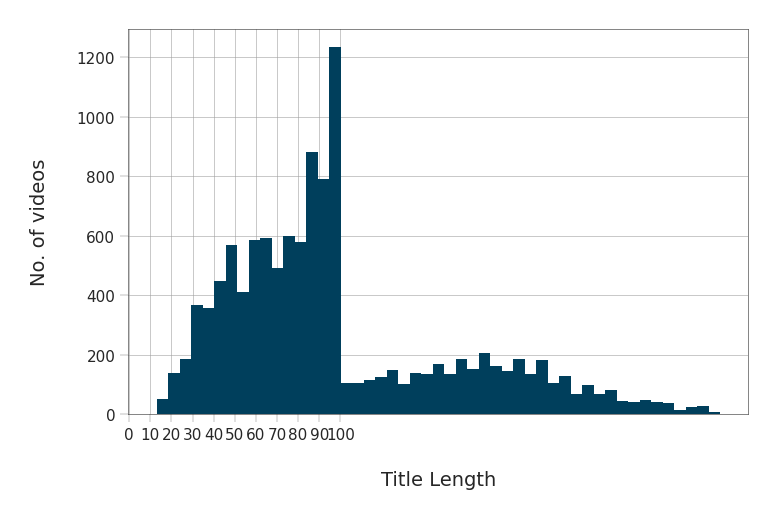

In [ ]:
df["title_length"] = df["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
_ = sns.distplot(df["title_length"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

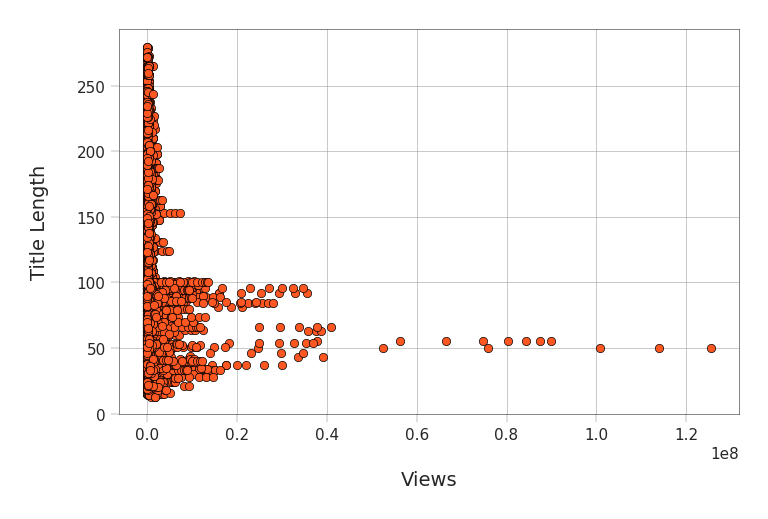

In [ ]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

In [ ]:
df.corr()

<ipython-input-59-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,contains_capitalized,title_length
category_id,1.00,-0.12,-0.09,-0.01,-0.02,0.02,0.06,NaN,0.04,0.03
views,-0.12,1.00,0.90,0.64,0.81,-0.03,-0.03,NaN,-0.01,-0.10
likes,-0.09,0.90,1.00,0.59,0.85,-0.04,-0.03,NaN,-0.01,-0.14
dislikes,-0.01,0.64,0.59,1.00,0.85,-0.01,-0.01,NaN,-0.02,-0.04
comment_count,-0.02,0.81,0.85,0.85,1.00,-0.02,-0.02,NaN,-0.01,-0.09
comments_disabled,0.02,-0.03,-0.04,-0.01,-0.02,1.00,0.36,NaN,-0.04,0.14
ratings_disabled,0.06,-0.03,-0.03,-0.01,-0.02,0.36,1.00,NaN,-0.02,0.05
video_error_or_removed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contains_capitalized,0.04,-0.01,-0.01,-0.02,-0.01,-0.04,-0.02,NaN,1.00,-0.26
title_length,0.03,-0.10,-0.14,-0.04,-0.09,0.14,0.05,NaN,-0.26,1.00


<ipython-input-61-6f322953c335>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)


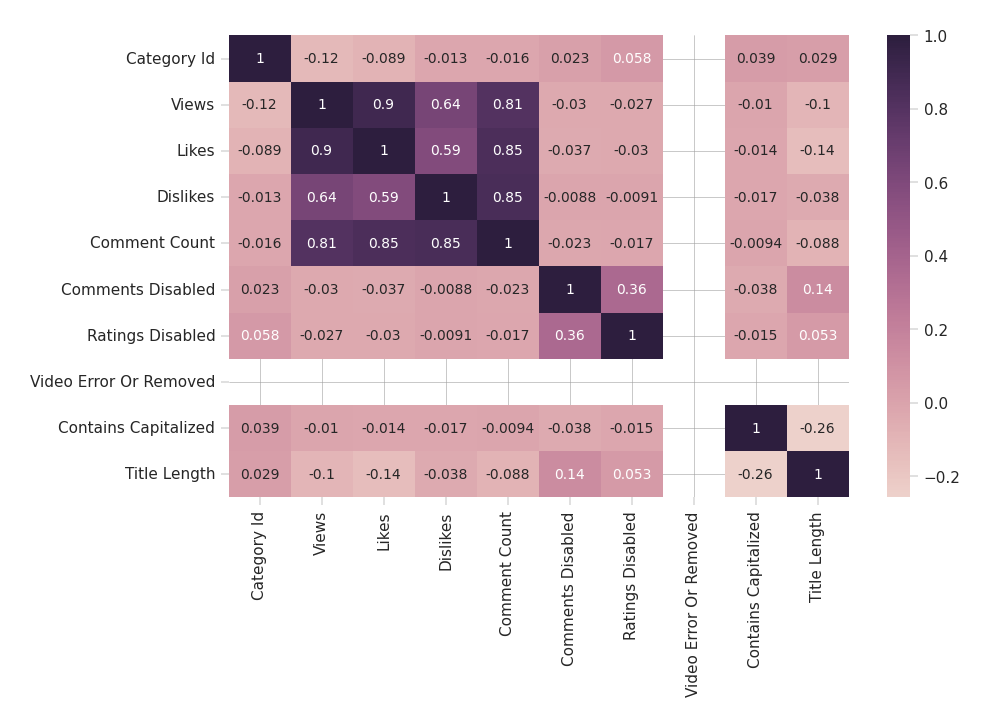

In [ ]:
h_labels = [x.replace('_', ' ').title() for x in
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

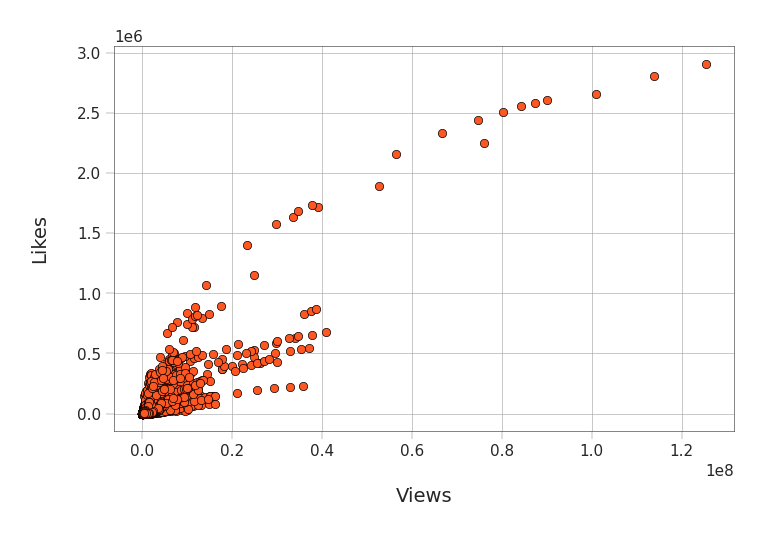

In [ ]:
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Likes")

In [ ]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('|', 11807),
 ('-', 4087),
 ('2017', 1622),
 ('||', 1208),
 ('Episode', 1004),
 ('Movie', 691),
 ('2018', 674),
 ('Full', 610),
 ('News', 594),
 ('The', 580),
 ('&', 550),
 ('December', 483),
 ('Telugu', 480),
 ('in', 463),
 ('Song', 459),
 ('Video', 423),
 ('to', 408),
 ('Trailer', 398),
 ('Official', 395),
 ('Latest', 390),
 ('New', 390),
 ('on', 376),
 ('and', 365),
 (':', 358),
 ('2', 352)]

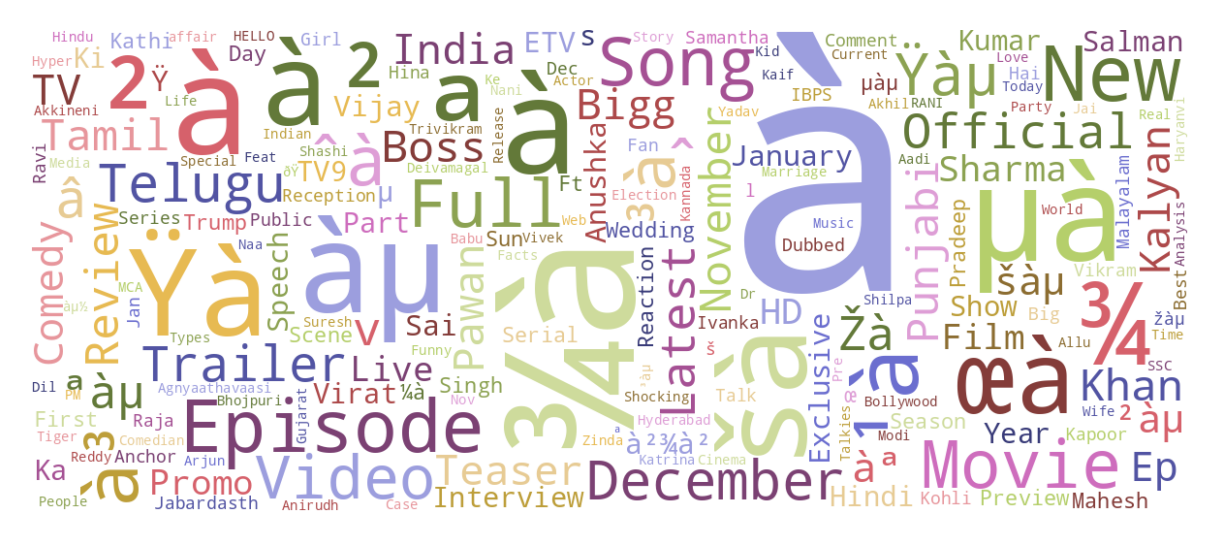

In [ ]:
# wc = wordcloud.WordCloud(width=1200, height=600, collocations=False, stopwords=None, background_color="white", colormap="tab20b").generate_from_frequencies(dict(Counter(title_words).most_common(150)))
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

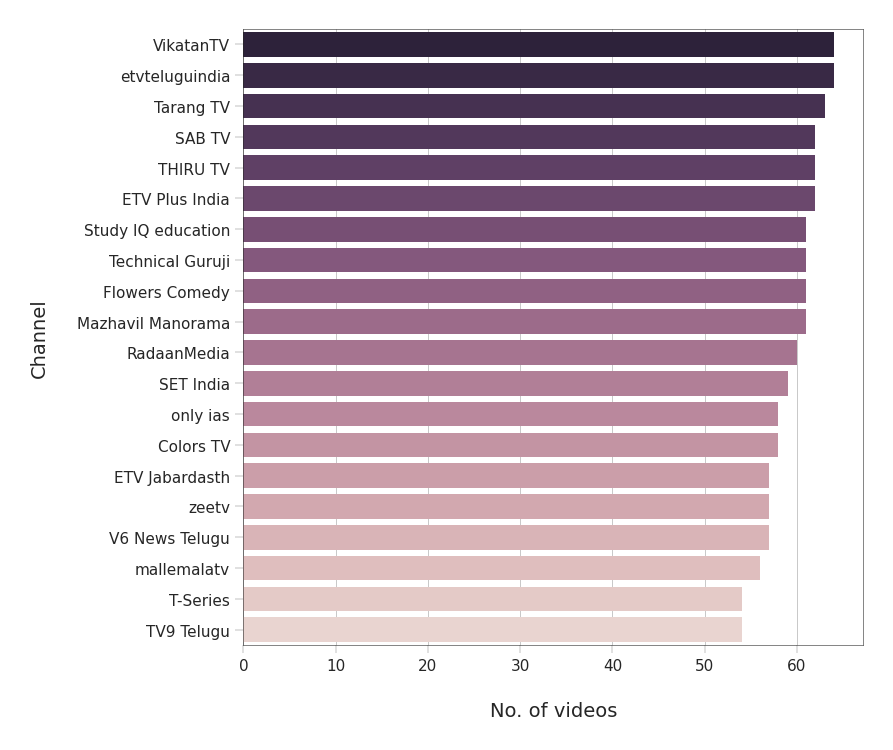

In [ ]:
cdf = df.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")

In [ ]:
with open("/content/drive/MyDrive/youtube.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

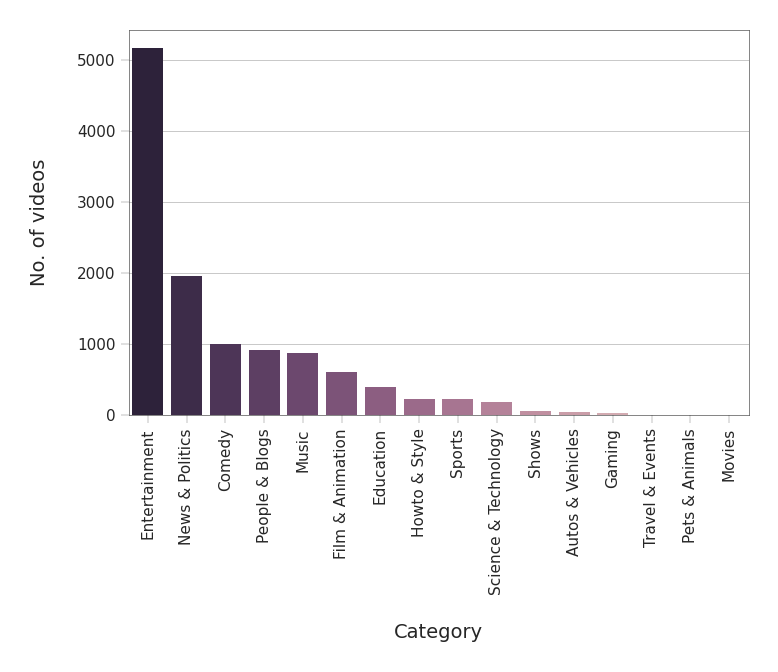

In [ ]:
cdf = df["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
fig, ax = plt.subplots()
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf,
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="No. of videos")

In [ ]:
df["publishing_day"] = df["publish_time"].apply(
    lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
df["publishing_hour"] = df["publish_time"].apply(lambda x: x[11:13])
df.drop(labels='publish_time', axis=1, inplace=True)

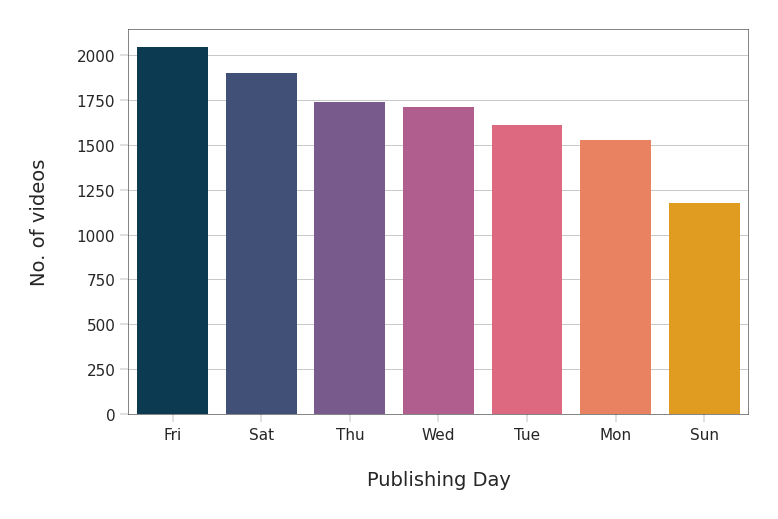

In [ ]:
cdf = df["publishing_day"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "publishing_day", "publishing_day": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_day", y="No_of_videos", data=cdf,
                palette=sns.color_palette(['#003f5c', '#374c80', '#7a5195',
                                           '#bc5090', '#ef5675', '#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Publishing Day", ylabel="No. of videos")

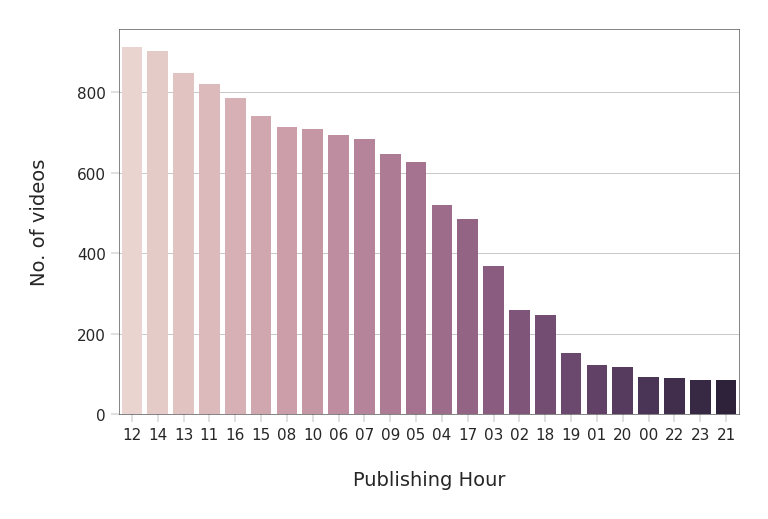

In [ ]:
cdf = df["publishing_hour"].value_counts().to_frame().reset_index()\
        .rename(columns={"index": "publishing_hour", "publishing_hour": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_hour", y="No_of_videos", data=cdf,
                palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel="Publishing Hour", ylabel="No. of videos")

KeyError: ignored

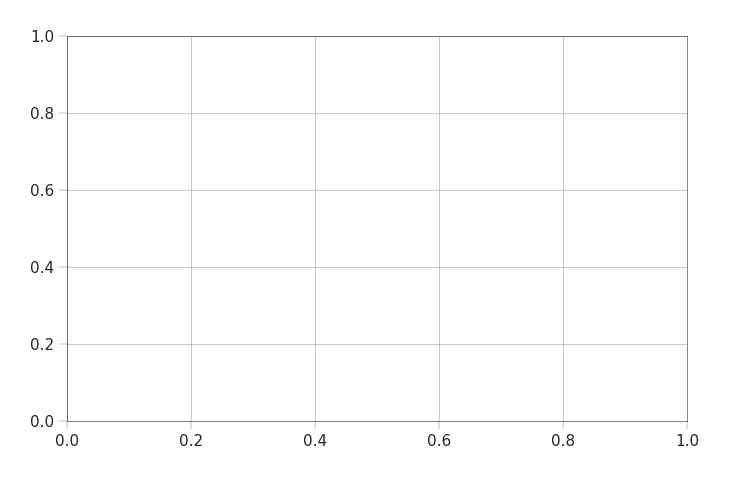

In [ ]:
value_counts = df["video_error_or_removed"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'],
        colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Video Error or Removed?')

In [ ]:
df["video_error_or_removed"].value_counts()

False    11713
Name: video_error_or_removed, dtype: int64

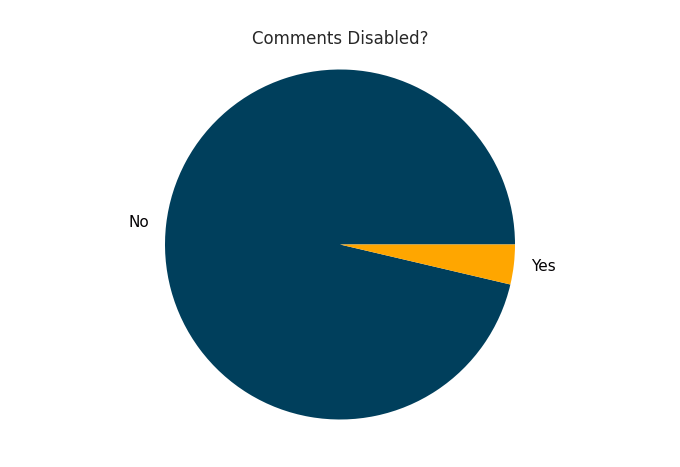

In [ ]:
value_counts = df["comments_disabled"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie(x=[value_counts[False], value_counts[True]], labels=['No', 'Yes'],
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Comments Disabled?')

In [ ]:
df["comments_disabled"].value_counts(normalize=True)

False   0.96
True    0.04
Name: comments_disabled, dtype: float64

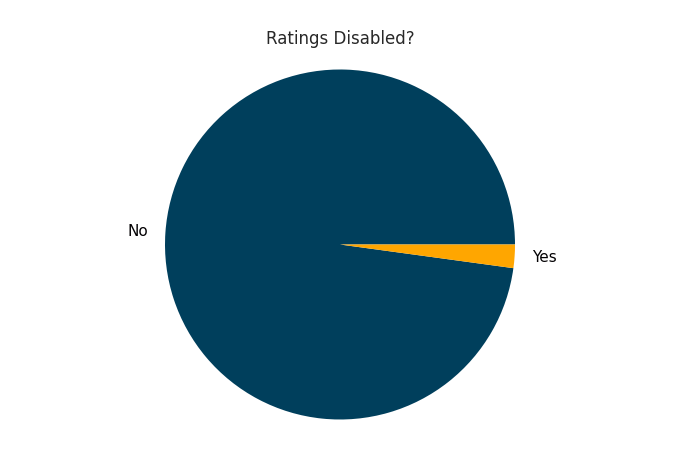

In [ ]:
value_counts = df["ratings_disabled"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'],
            colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Ratings Disabled?')